# Kepler-16 lightcurve preparation for new CB search trials

In [26]:
import numpy as np
import matplotlib.pyplot as p
import kepselfflatten as ksf
from astropy.io import fits

%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [29]:
#take in lightcurve data

lc = fits.open('K16_jnd.fits')
time = lc[1].data['TIME']
flux = lc[1].data['PDCSAP_FLUX']
sapflux = lc[1].data['SAP_FLUX']
err = lc[1].data['PDCSAP_FLUX_ERR']
nancheck = np.isnan(time) | np.isnan(flux) | np.isnan(err)
time, flux, err, sapflux = time[~nancheck], flux[~nancheck], err[~nancheck], sapflux[~nancheck]
sort = np.argsort(time)
time, flux, err, sapflux = time[sort],flux[sort], err[sort], sapflux[sort]

<IPython.core.display.Javascript object>


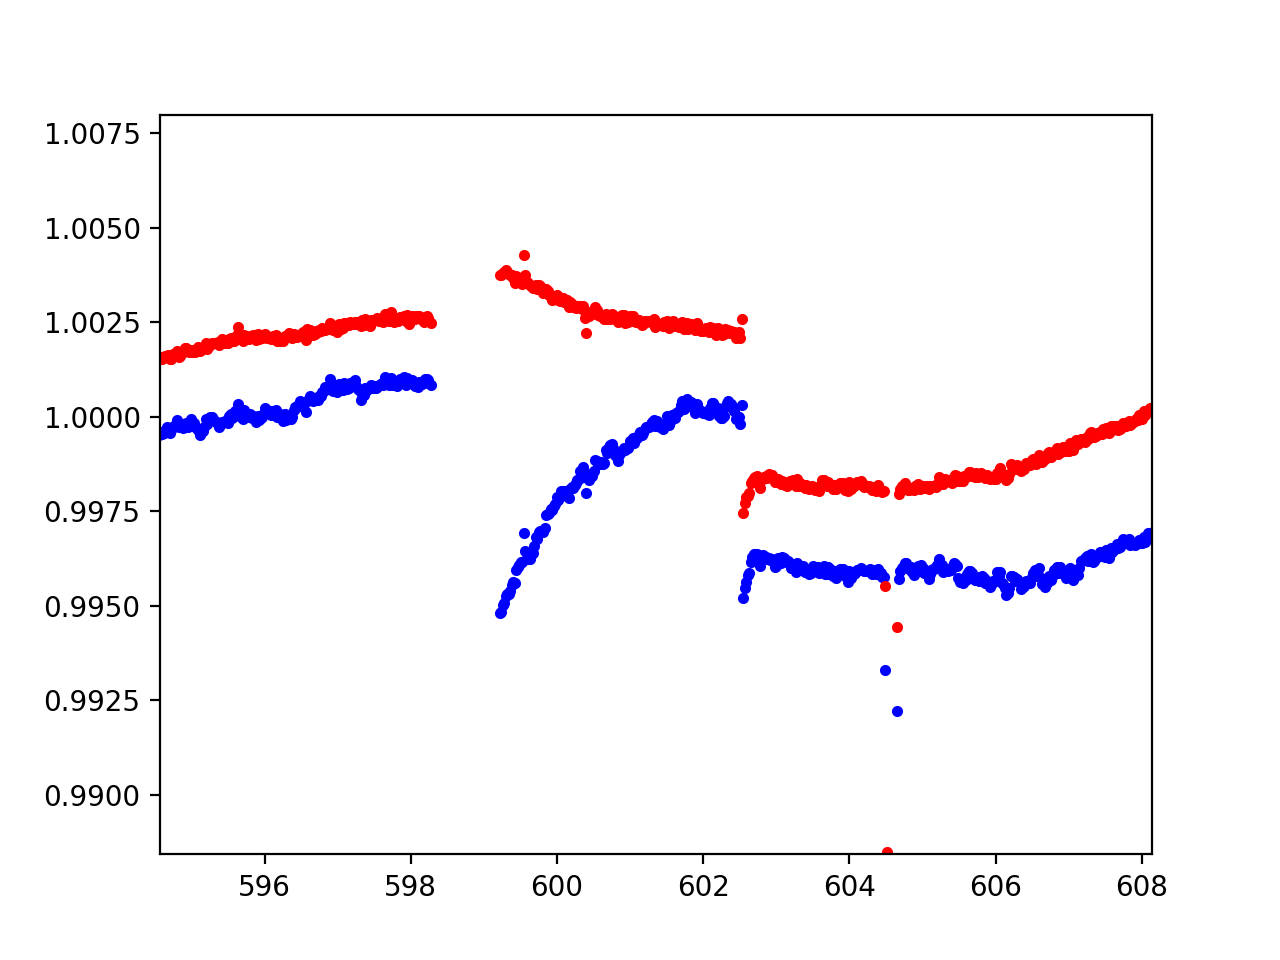

[  120.5388864    120.5593206    120.5797547  ...,  1590.96057108
  1590.98100516  1591.00143944]
120.538886397


<IPython.core.display.Javascript object>


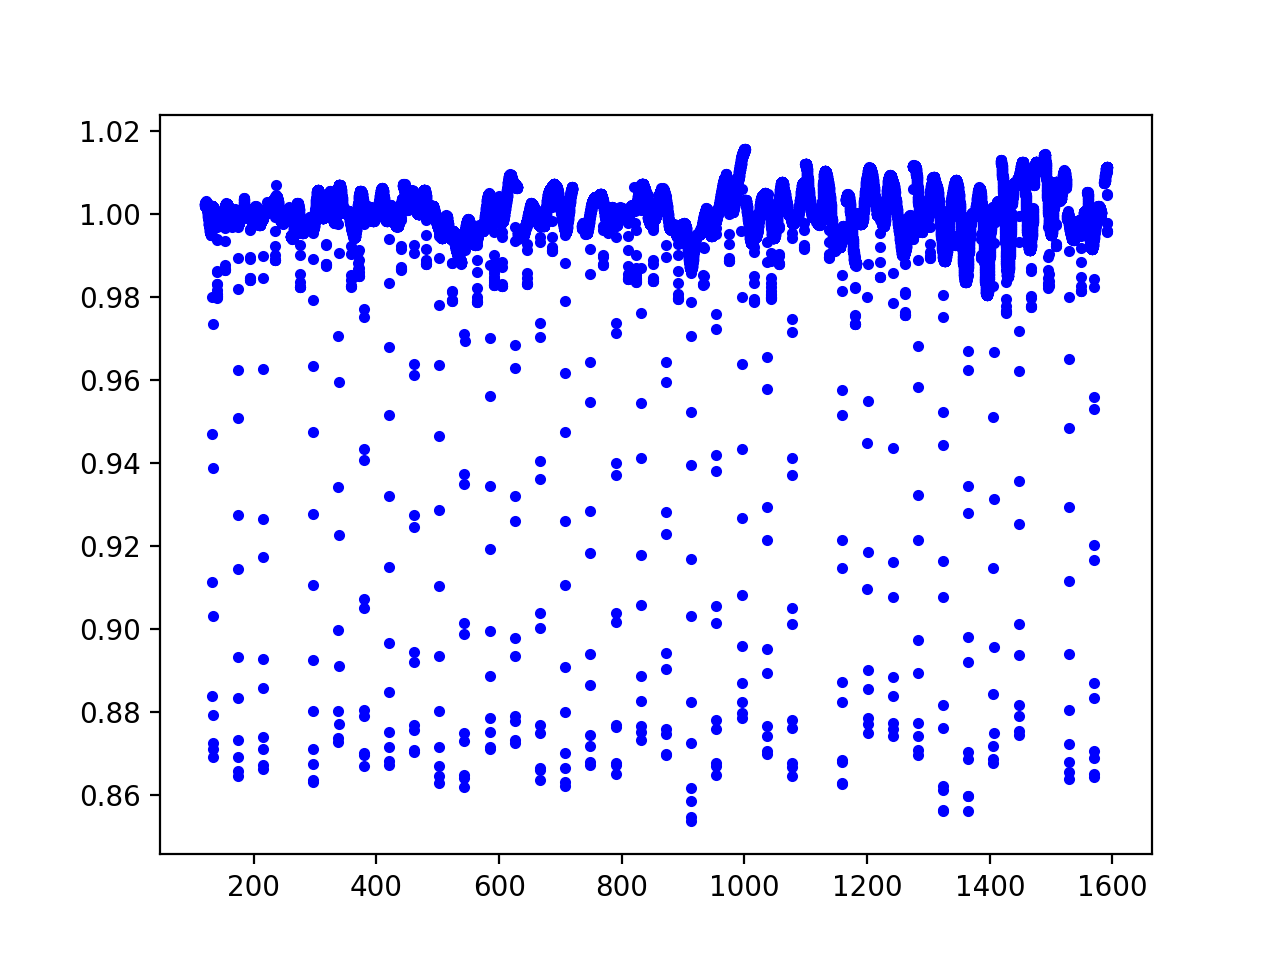

In [31]:
p.figure()
p.plot(time,flux,'b.')
p.plot(time,sapflux,'r.')
#quarter-stitched, but otherwise messy, lightcurve
print(time)
print(np.min(time))
p.figure()
p.plot(time,sapflux,'b.')

In [22]:
#step 1 - remove activity trend and discontinuities
winsize = 3.
stepsize = 0.1
polydegree = 3
niter = 10
sigmaclip = 5
gapthreshold = 0.5
plot = False
transitcut = True
t_per = 41.0775867  #binary period - will ignore primary eclipses 
                    #(not secondaries or transits, though these should be iterated out
t_t0 = 54965.657634 - 54833
t_dur = 0.3

lcf =   ksf.Kepflatten(time-time[0],flux,err,np.zeros(len(time)),
                       winsize,stepsize,polydegree,niter,sigmaclip,
                       gapthreshold,time[0],False,True,
                       t_per,t_t0,t_dur)        
print(lcf)


[[  1.20538886e+02   9.99717960e-01   5.83457368e-05   0.00000000e+00]
 [  1.20559321e+02   9.99947561e-01   5.81607273e-05   0.00000000e+00]
 [  1.20579755e+02   9.99872847e-01   5.82130815e-05   0.00000000e+00]
 ..., 
 [  1.59096057e+03   1.00000084e+00   5.90885065e-05   0.00000000e+00]
 [  1.59098101e+03   9.99830015e-01   5.90558957e-05   0.00000000e+00]
 [  1.59100144e+03   9.99926126e-01   5.90113923e-05   0.00000000e+00]]


<IPython.core.display.Javascript object>


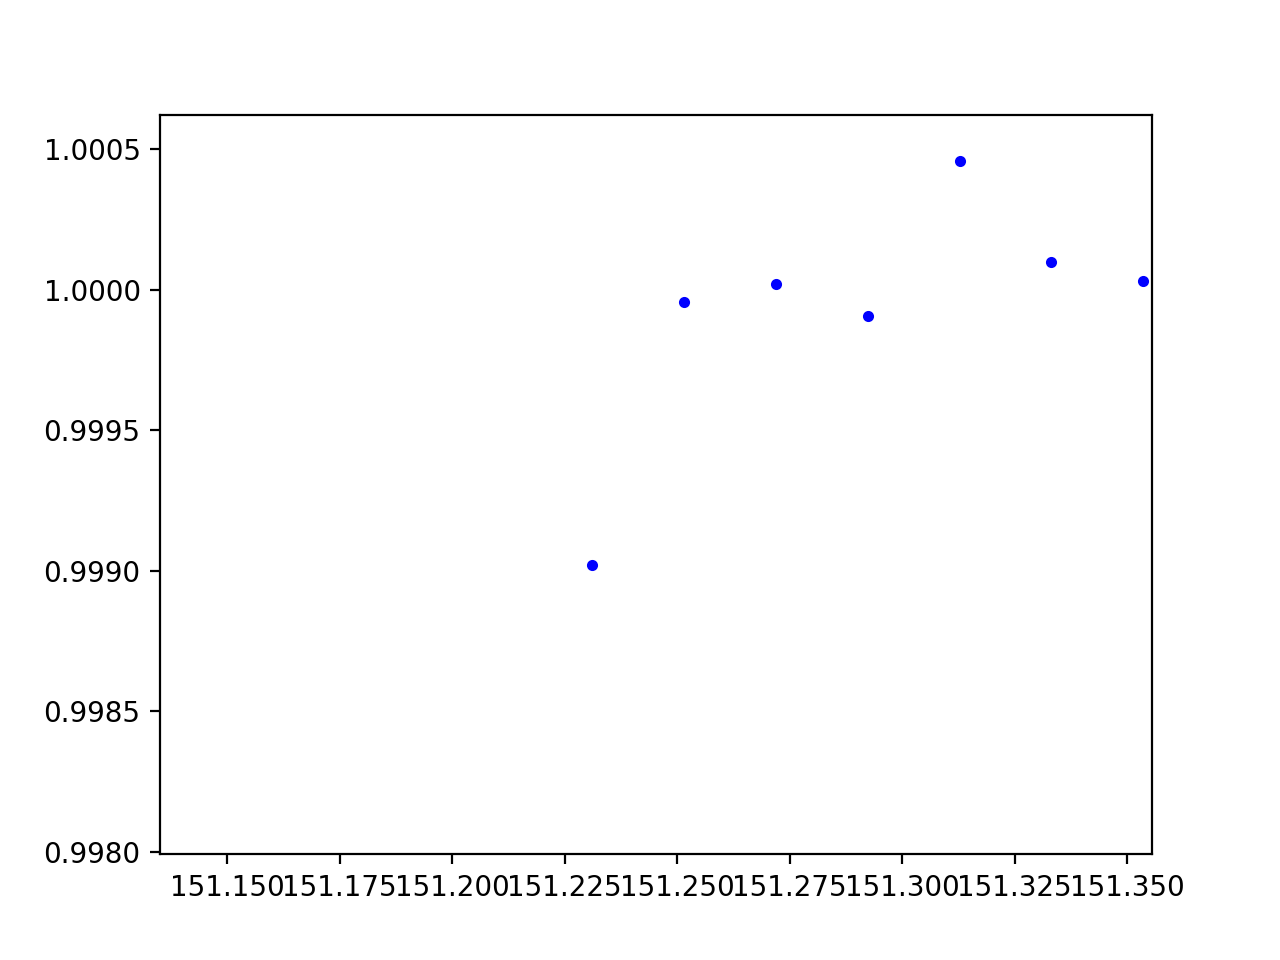

<IPython.core.display.Javascript object>


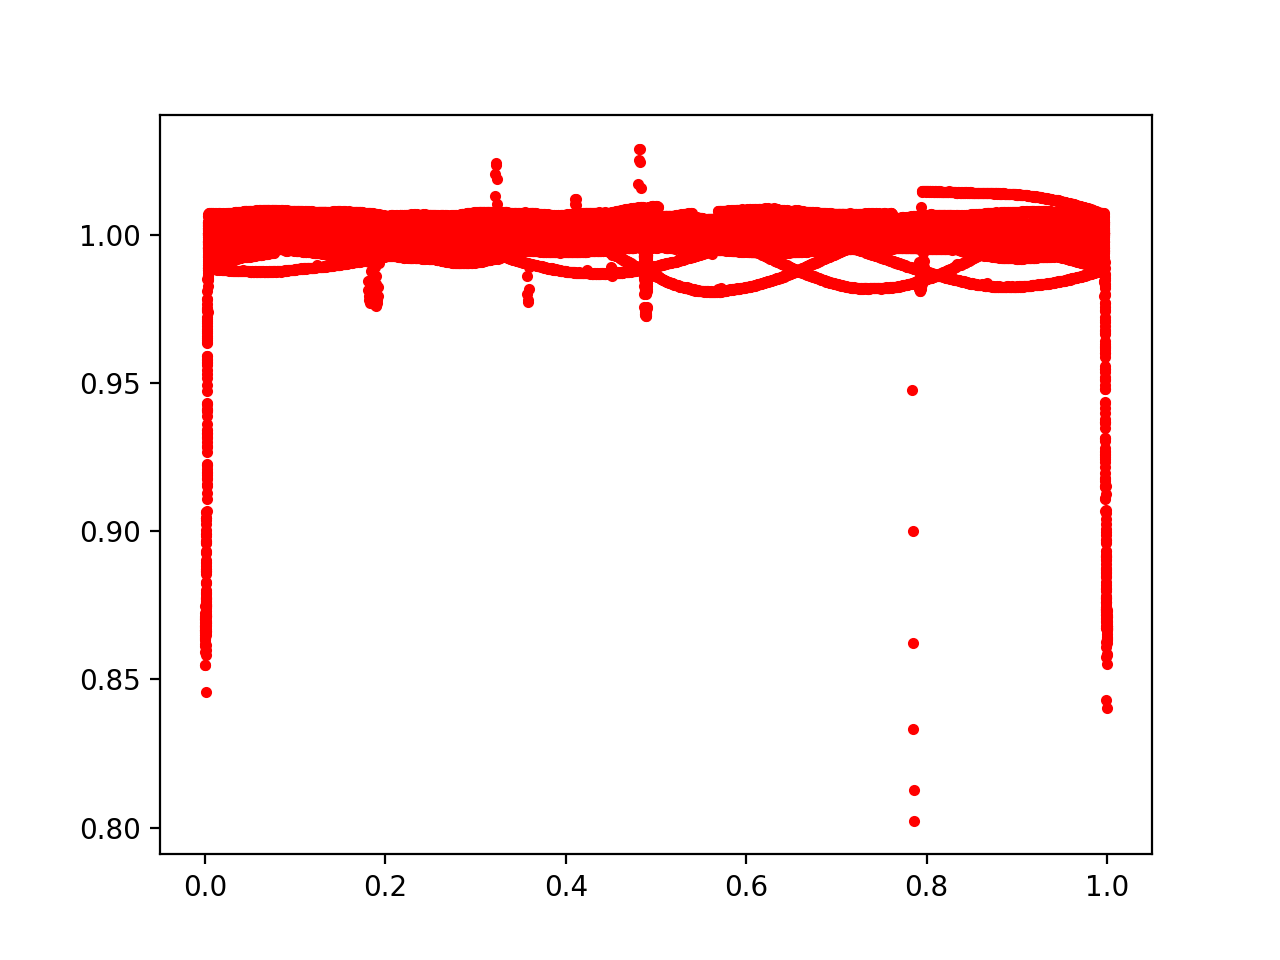

<IPython.core.display.Javascript object>


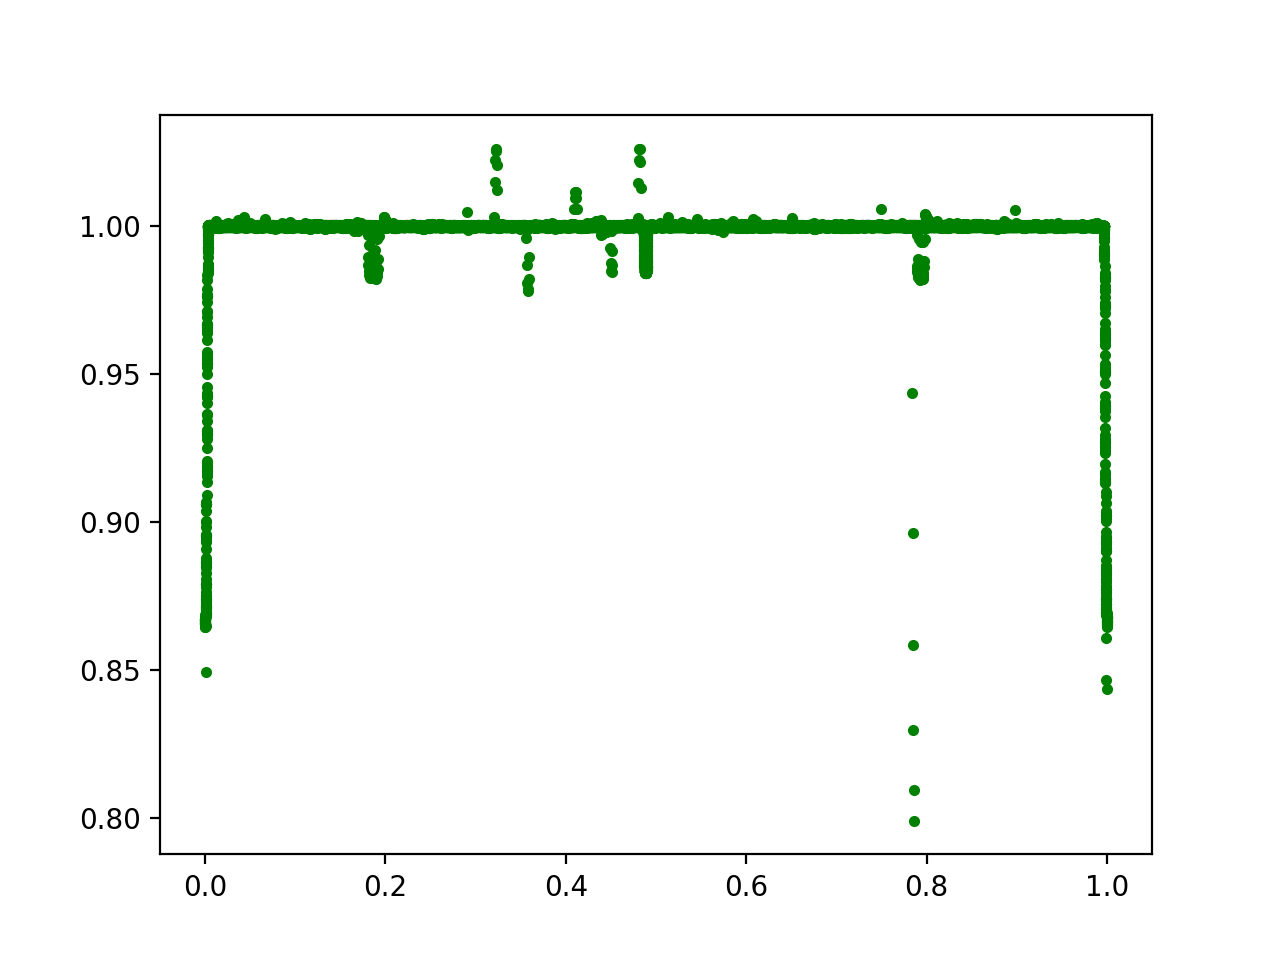

In [28]:
p.figure()
p.plot(lcf[:,0],lcf[:,1],'b.')
phase = np.mod(lcf[:,0]-t_t0,t_per)/t_per
p.figure()
p.plot(phase,flux,'r.')
p.figure()
p.plot(phase,lcf[:,1],'g.')


<IPython.core.display.Javascript object>


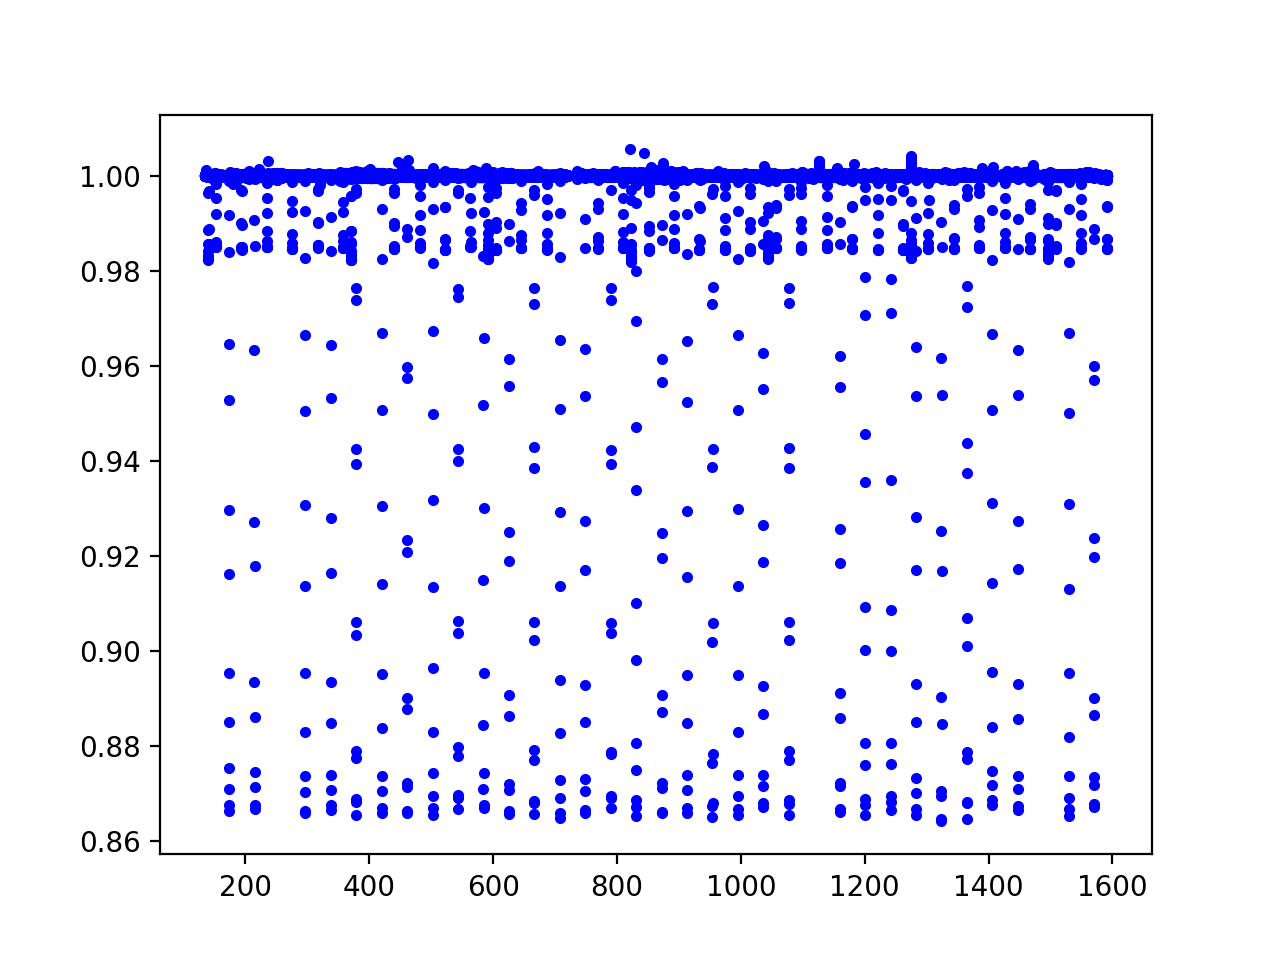

<IPython.core.display.Javascript object>


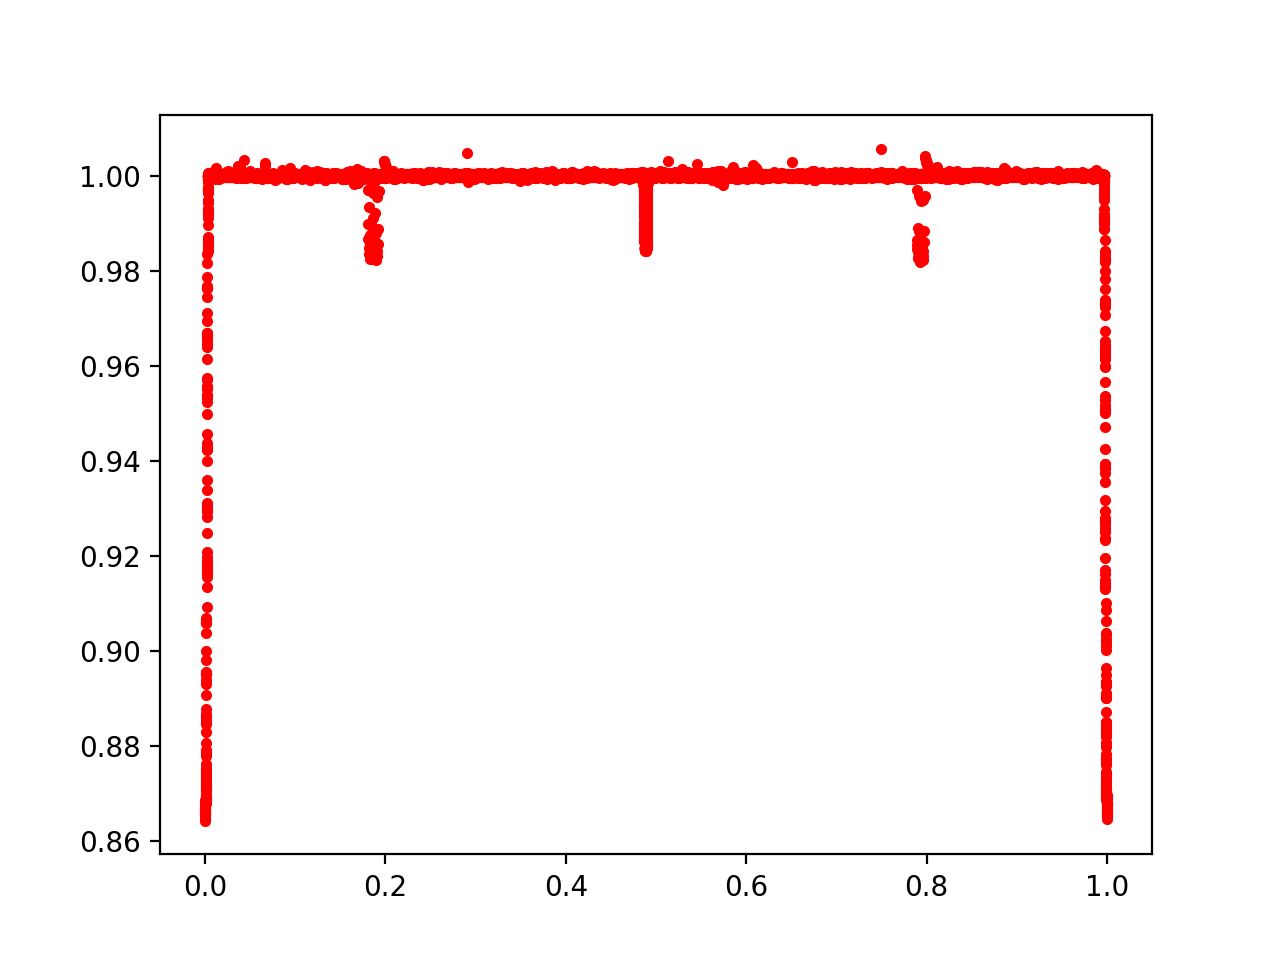

In [39]:
#remove PDC induced outliers near start:
time, flux, err = lcf[:,0], lcf[:,1], lcf[:,2]

timecut = np.min(np.where(time>135)) #removes first extra deep binary eclipse
time, flux, err = time[timecut:], flux[timecut:], err[timecut:]

tmin = 145.5
tmax = 152.5
cut = (time>tmin) & (time<tmax) & ((flux>1.002) | (flux<0.9988))
time, flux, err = time[~cut], flux[~cut], err[~cut]
tmin = 164.8
tmax = 165.1
cut = (time>tmin) & (time<tmax) & ((flux>1.002) | (flux<0.9988))
time, flux, err = time[~cut], flux[~cut], err[~cut]
tmin = 602.08
tmax = 603.05
cut = (time>tmin) & (time<tmax)
time, flux, err = time[~cut], flux[~cut], err[~cut]

p.figure()
p.plot(time,flux,'b.')


phase = np.mod(time-t_t0,t_per)/t_per
p.figure()
p.plot(phase,flux,'r.')


<IPython.core.display.Javascript object>


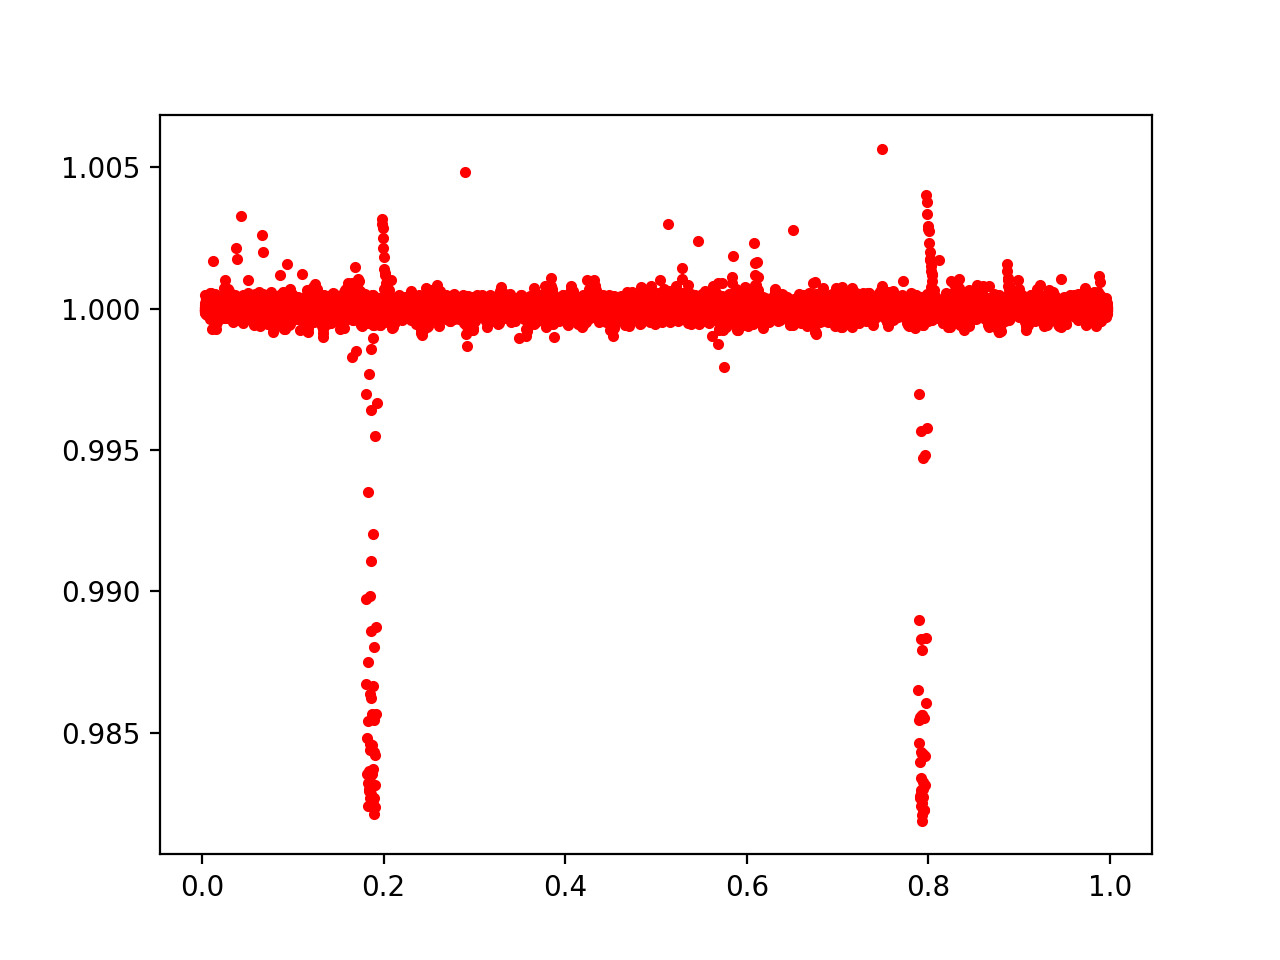

In [41]:
#given the very narrow K16 eclipses, cut them from the lightcurve:
bin_per = 41.0775867  #binary period - will ignore primary eclipses 
                    #(not secondaries or transits, though these should be iterated out
bin_t0 = 54965.657634 - 54833
pri_phase = 0.0033 #in phase (half of eclipse, assumes centred at 0)
sec_start = 0.4858
sec_end = 0.49093

cut = (phase<pri_phase) | (phase > (1-pri_phase)) | ( (phase>sec_start) & (phase<sec_end) )
time, flux, err, phase = time[~cut], flux[~cut], err[~cut], phase[~cut]

p.figure()
p.plot(phase,flux,'r.')

In [43]:
#save lightcurve for other search tests

output = np.zeros(len(time))
output = np.array([time,flux,err]).T
np.savetxt('K16_clean_noecl.txt',output)